In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import re

Load the log data from the CSV file (replace with your own dataset path)

In [2]:
log_data = pd.read_csv("/workspaces/Log-Parsing-and-Errors/error.csv")

Keep only the '_raw' column

In [3]:
log_data = log_data[["_raw"]]

# for each log message, remove the log messages which don't contain "ERROR" in the first 100 characters<br>
for i in range(len(log_data)):<br>
    if "ERROR" not in log_data["_raw"][i][:100]:<br>
        log_data = log_data.drop(i)

Reset the index

In [4]:
log_data = log_data.reset_index(drop=True)

for each log message, remove the everything before the third :

In [5]:
for i in range(len(log_data)):
    log_data["_raw"][i] = log_data["_raw"][i].split(":", 3)[-1]

for each log message, truncate the log messages after the first 100 characters

In [6]:
for i in range(len(log_data)):
    log_data["_raw"][i] = log_data["_raw"][i][:500]

for each log message, remove everything after the first line break character

In [7]:
for i in range(len(log_data)):
    log_data["_raw"][i] = log_data["_raw"][i].split("\n", 1)[0]

Data preprocessing: remove non-alphanumeric characters and convert to lowercase

In [8]:
log_data["_raw"] = log_data["_raw"].str.replace("[^a-zA-Z0-9 ]", "").str.lower()

Define a regular expression pattern to match URLs

In [9]:
url_pattern = (
    r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
)

Function to remove URLs from a text

In [10]:
def remove_urls(text):
    return re.sub(url_pattern, "", text)

Apply the remove_urls function to each log message

In [11]:
log_data["_raw"] = log_data["_raw"].apply(remove_urls)

In [12]:
data = {
    "log_message": log_data["_raw"].tolist(),
}

In [13]:
df = pd.DataFrame(data)

Vectorize log messages using TF-IDF

In [14]:
vectorizer = TfidfVectorizer(max_features=500, stop_words="english")
log_vectors = vectorizer.fit_transform(df["log_message"])

In [15]:
k_range = range(1, 20)

In [16]:
sse = []

In [17]:
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(log_vectors)
    sse.append(kmeans.inertia_)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


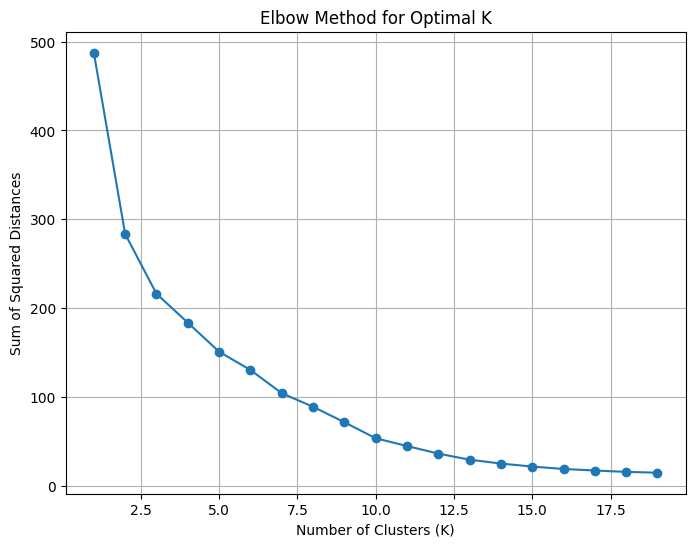

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

Initialize an empty list to store the silhouette scores

In [19]:
silhouette_scores = []

Iterate through each value of K

In [20]:
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(log_vectors)

    # Check if the number of unique labels is less than 2
    if len(np.unique(kmeans.labels_)) < 2:
        silhouette_avg = -1  # Set a placeholder score (e.g., -1) for such cases
    else:
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(log_vectors, labels)
    silhouette_scores.append(silhouette_avg)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 1

Plot the Silhouette Score graph

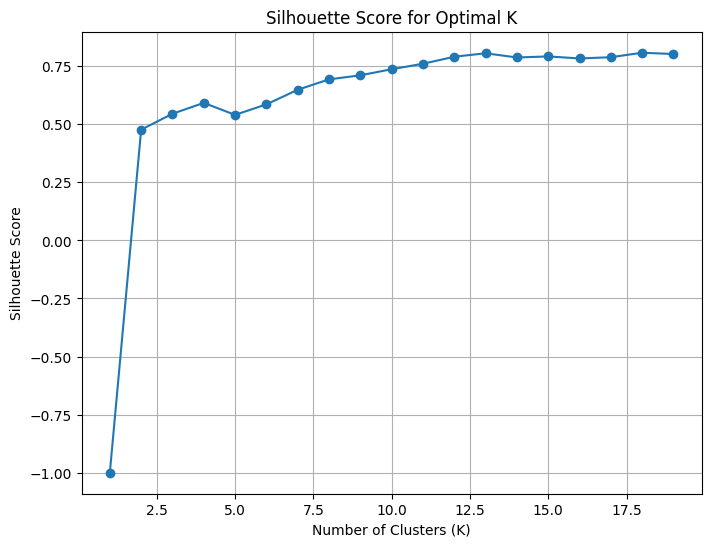

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.grid(True)
plt.show()

Train a K-Means clustering model

In [22]:
n_clusters = 5  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(log_vectors)

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=5)

Extract keywords from cluster centroids

In [23]:
cluster_keywords = {}
for cluster_id in range(n_clusters):
    # Get indices of log messages in this cluster
    cluster_indices = kmeans.labels_ == cluster_id

    # Extract keywords from the log messages in this cluster
    keywords = []
    for log_message in df.loc[cluster_indices, "log_message"]:
        keywords += re.findall(r"\b\w+\b", log_message)

    # Count and rank keyword occurrences
    keyword_counts = pd.Series(keywords).value_counts()

    # Store the top keywords for this cluster
    cluster_keywords[cluster_id] = keyword_counts.index.tolist()[
        :5
    ]  # Adjust the number of keywords as needed

Print the identified patterns (top keywords for each cluster)

In [24]:
print("Identified Patterns:")
for cluster_id, keywords in cluster_keywords.items():
    print(f"Pattern {cluster_id + 1}: {', '.join(keywords)}")

Identified Patterns:
Pattern 1: servlet, service, for, dispatcherservlet, threw
Pattern 2: rddgwsatl04, prod, com, fedex, cloud
Pattern 3: nessus, header, error, request, http
Pattern 4: com, fedex, cloud, prod, refused
Pattern 5: exception, processing, errorpage, errorcode, 0


make a list of one message per cluster

In [25]:
cluster_messages = []
for cluster_id in range(n_clusters):
    # Get indices of log messages in this cluster
    cluster_indices = kmeans.labels_ == cluster_id

    # Extract keywords from the log messages in this cluster
    keywords = []
    for log_message in df.loc[cluster_indices, "log_message"]:
        keywords += re.findall(r"\b\w+\b", log_message)

    # Count and rank keyword occurrences
    keyword_counts = pd.Series(keywords).value_counts()

    # Store the top keywords for this cluster
    cluster_messages.append(df.loc[cluster_indices, "log_message"].tolist()[0])

print(cluster_messages)

In [26]:
for message in cluster_messages:
    print(f"cluster number: {cluster_messages.index(message) + 1} \n {message} \n")
# Replace 'YOUR_API_KEY' with your CohereAI API key
import cohere

cluster number: 1 
  servlet.service() for servlet [dispatcherservlet] in context with path [] threw exception 

cluster number: 2 
  request execution failed with message: i/o error on get request for "": connect to rddgwsatl04.prod.cloud.fedex.com:8094 [rddgwsatl04.prod.cloud.fedex.com/10.52.77.32] failed: connection refused (connection refused); nested exception is org.apache.http.conn.httphostconnectexception: connect to rddgwsatl04.prod.cloud.fedex.com:8094 [rddgwsatl04.prod.cloud.fedex.com/10.52.77.32] failed: connection refused (connection refused) 

cluster number: 3 
  a cookie header was received [${jndi:ldap://log4shell-generic-8molyf0ab2aqtscsyugh${lower:ten}.w.nessus.org/nessus}=${jndi:ldap://log4shell-generic-8molyf0ab2aqtscsyugh${lower:ten}.w.nessus.org/nessus};] that contained an invalid cookie. that cookie will be ignored. 

cluster number: 4 
  request execution failed with message: i/o error on put request for "": connect to rddgwslas03.prod.cloud.fedex.com:8094 [rdd

In [27]:
co = cohere.Client(
    "PQ50WPjjMsFSzUhZlMQaGTlS30MyRs9YkbuKfhHh"
)  # This is your trial API key

In [28]:
def generate_patterns(log_messages, num_patterns=5):
    patterns = []

    # Iterate through log messages
    for message in log_messages:
        response = co.chat(
            model="command-nightly",
            message=f"Please generate a regex pattern to match the following log message: {message}\n\nonly give regex and nothing else strictly",
            temperature=0.3,
            #   chat_history=[{"user_name": "User", "message": f"Please generate a regex pattern to match the following log message: {message}\n\nonly give regex and nothing else strictly"}],
            prompt_truncation="auto",
            # stream=True,
            citation_quality="accurate",
            connectors=[{"id": "web-search"}],
        )
        # print(response)
        generated_patterns = response.text
        print("Prediction: {}".format(generated_patterns))
        # Extract generated patterns from the response
        patterns.append({"log_message": message, "patterns": generated_patterns})
    return patterns

Generate patterns for each cluster

In [29]:
cluster_patterns = generate_patterns(cluster_messages)

Prediction: /Servlet\.service\(\) for servlet \[\w+\] in context with path \[\w+\] threw exception \[\w+\]/g
Prediction: ```
^request execution failed with message: i\/o error on get request for "\": connect to rddgwsatl04\.prod\.cloud\.fedex\.com:8094 \[rddgwsatl04\.prod\.cloud\.fedex\.com\/10\.52\.77\.32\] failed: connection refused \(\connection refused\); nested exception is org\.apache\.http\.conn\.httphostconnectexception: connect to rddgwsatl04\.prod\.cloud\.fedex\.com:8094 \[rddgwsatl04\.prod\.cloud\.fedex\.com\/10\.52\.77\.32\] failed: connection refused \(\connection refused\)$
``` 
This regex will match any log message that begins with "request execution failed with message: ", followed by "i/o error on get request for \"\", "connect to rddgwsatl04.prod.cloud.fedex.com:8094 [rddgwsatl04.prod.cloud.fedex.com/10.52.77.32] failed: connection refused "(connection refused); nested exception is org.apache.http.conn.httphostconnectexception: connect to rddgwsatl04.prod.cloud.fedex.

Print the identified patterns (top keywords for each cluster)

In [30]:
print("Identified Patterns:")
for cluster_id, patterns in enumerate(cluster_patterns):
    print(f"Pattern {cluster_id + 1}: {patterns['patterns']}")

Identified Patterns:
Pattern 1: /Servlet\.service\(\) for servlet \[\w+\] in context with path \[\w+\] threw exception \[\w+\]/g
Pattern 2: ```
^request execution failed with message: i\/o error on get request for "\": connect to rddgwsatl04\.prod\.cloud\.fedex\.com:8094 \[rddgwsatl04\.prod\.cloud\.fedex\.com\/10\.52\.77\.32\] failed: connection refused \(\connection refused\); nested exception is org\.apache\.http\.conn\.httphostconnectexception: connect to rddgwsatl04\.prod\.cloud\.fedex\.com:8094 \[rddgwsatl04\.prod\.cloud\.fedex\.com\/10\.52\.77\.32\] failed: connection refused \(\connection refused\)$
``` 
This regex will match any log message that begins with "request execution failed with message: ", followed by "i/o error on get request for \"\", "connect to rddgwsatl04.prod.cloud.fedex.com:8094 [rddgwsatl04.prod.cloud.fedex.com/10.52.77.32] failed: connection refused "(connection refused); nested exception is org.apache.http.conn.httphostconnectexception: connect to rddgwsatl0